#### **Javier Pérez Vargas - d21c017**

## Práctica - Aprendizaje Supervisado

Dado un conjunto de datos de diferentes reseñas sobre distintas aerolíneas, vamos a hacer un análisis sobre la efectividad de diferentes modelos (KNN, SVM...) para la predicción de si el viajero acaba satisfecho con la aerolínea o no. El conjunto de datos utiliza 24 features (numéricas, binarias y categóricas) y contiene +100000 instancias. No obstante, nosotros solo utilizaremos un subconjunto de todas ellas.

Algunas de las features del dataset son:
- Edad
- Tipo de viaje: Objetivo del viaje (personal o de negocios)
- Clase: Clase en la que iba el pasajero (Business, Eco, Eco Plus)
- Distancia del vuelo
- Otras muchas variables en las que el viajero puntúa del 0-5 su satisfacción con respecto a otros aspectos (limpieza, facilidad para reserva oline, servicio wi-fi en el vuelo...)
- ...

Para más información, ver https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction

### 1. Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### 2. Preparamiento de los datos

2.1 Antes de comenzar, vamos a ver cómo es el conjunto de datos.

In [2]:
original_data = pd.read_csv('archive/data.csv', index_col=0)
original_data.shape

(103904, 24)

Tenemos un dataset de +100000 filas. Vamos a coger una muestra de 5000 filas para la práctica.

In [3]:
data = original_data.sample(n=5000, random_state=1)
data.head(5)

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
65830,23509,Male,Loyal Customer,41,Business travel,Eco,303,5,3,3,...,5,4,3,3,5,5,5,0,0.0,satisfied
41026,31011,Female,Loyal Customer,18,Business travel,Business,391,1,5,5,...,1,4,3,3,1,4,1,17,17.0,neutral or dissatisfied
95867,29345,Female,Loyal Customer,13,Personal Travel,Eco Plus,569,2,4,2,...,1,5,4,4,5,5,1,0,0.0,neutral or dissatisfied
75679,50242,Male,disloyal Customer,23,Business travel,Eco,109,1,0,1,...,3,2,5,5,3,1,3,0,0.0,neutral or dissatisfied
52958,22244,Male,Loyal Customer,23,Personal Travel,Business,83,4,5,0,...,5,3,5,4,3,5,5,0,0.0,neutral or dissatisfied


Eliminamos los datos nulos y la columna 'id' que no es informativa.

In [4]:
data = data.dropna(axis=0)
data = data.drop(['id'], axis=1)

Preprocesamos los datos. Para ello, usamos 'ColumnTransformer' de scikitlearn para automatizar el proceso. 

**Importante**: Haremos un preprocesamiento diferente para el árbol de decisión. Con el objetivo de mejorar la interpretabilidad del modelo, vamos a usar datos NO escalados para el árbol de decisión, y así después, cuando veamos las reglas generadas por el árbol, podremos entender mejor cada decisión. El escalado de datos no afecta al árbol de decisión ya que no se basa en distancias.

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
numeric_cols = ['Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient',
                'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding',
                'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service',
                'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness',
                'Departure Delay in Minutes', 'Arrival Delay in Minutes']

preprocessor_scaled = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(sparse_output=False), categorical_cols)
    ],
    remainder='drop')

preprocessor_not_scaled = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False), categorical_cols)
    ],
    remainder='passthrough')

preprocessor_scaled.set_output(transform='pandas')
preprocessor_not_scaled.set_output(transform='pandas')

transformed_data_not_scaled = preprocessor_not_scaled.fit_transform(data)
transformed_data_scaled = preprocessor_scaled.fit_transform(data)
transformed_data_scaled['satisfaction'] = data['satisfaction']

In [6]:
transformed_data_not_scaled.iloc[[0], :]

,cat__Gender_Female,cat__Gender_Male,cat__Customer Type_Loyal Customer,cat__Customer Type_disloyal Customer,cat__Type of Travel_Business travel,cat__Type of Travel_Personal Travel,cat__Class_Business,cat__Class_Eco,cat__Class_Eco Plus,remainder__Age,...,remainder__Inflight entertainment,remainder__On-board service,remainder__Leg room service,remainder__Baggage handling,remainder__Checkin service,remainder__Inflight service,remainder__Cleanliness,remainder__Departure Delay in Minutes,remainder__Arrival Delay in Minutes,remainder__satisfaction
65830,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,41,...,5,4,3,3,5,5,5,0,0.0,satisfied


In [7]:
transformed_data_scaled.iloc[[0], :]

,num__Age,num__Flight Distance,num__Inflight wifi service,num__Departure/Arrival time convenient,num__Ease of Online booking,num__Gate location,num__Food and drink,num__Online boarding,num__Seat comfort,num__Inflight entertainment,...,cat__Gender_Female,cat__Gender_Male,cat__Customer Type_Loyal Customer,cat__Customer Type_disloyal Customer,cat__Type of Travel_Business travel,cat__Type of Travel_Personal Travel,cat__Class_Business,cat__Class_Eco,cat__Class_Eco Plus,satisfaction
65830,0.109503,-0.891285,1.716364,-0.030071,0.161829,0.019418,1.374099,1.304611,1.188079,1.257258,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,satisfied


2.2 Una vez vistos y preprocesados los datos, vamos a comenzar diviviéndolos en conjunto de *train* y de *test*. Como hemos dicho, guardamos la copia sin estandarizar los datos para el árbol de decisión.

In [8]:
from sklearn.model_selection import train_test_split

X_not_scaled = transformed_data_not_scaled.drop('remainder__satisfaction', axis=1)
y_not_scaled = transformed_data_not_scaled['remainder__satisfaction']

X_train_not_scaled, X_test_not_scaled, y_train_not_scaled, y_test_not_scaled = train_test_split(X_not_scaled, y_not_scaled, test_size=0.2, random_state=45)

X_scaled = transformed_data_scaled.drop('satisfaction', axis=1)
y_scaled = transformed_data_scaled['satisfaction']

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=45)

Podemos ver cuáles son las variables que tienen más correlación con nuestra variable objetivo y que, presumiblemente, serán las más explicativas.

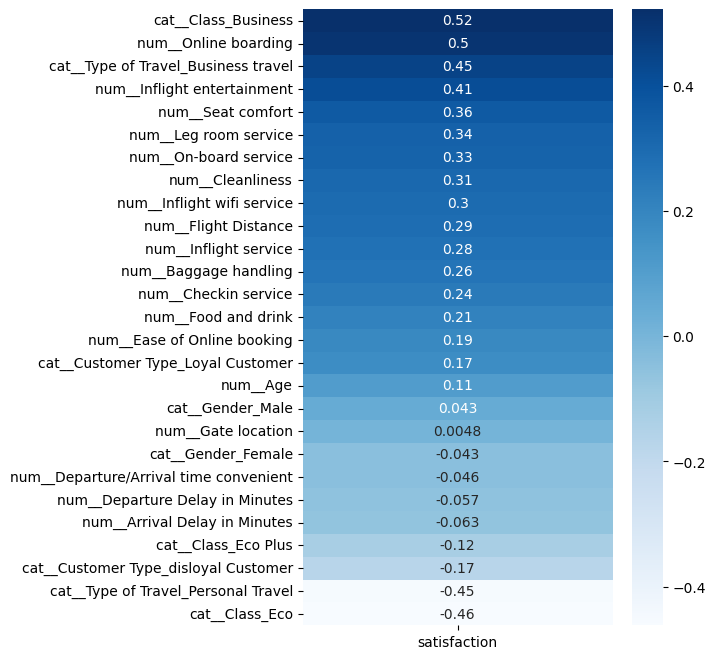

In [9]:
X_train_copy = X_train_scaled.copy()
X_train_copy['satisfaction'] = y_train_scaled
X_train_copy['satisfaction'] = X_train_copy['satisfaction'].replace({'neutral or dissatisfied': 0, 'satisfied': 1})

corr = X_train_copy.corr()
corr = corr[['satisfaction']]
corr = corr.sort_values(by='satisfaction', ascending=False)
corr = corr.drop(['satisfaction'], axis=0)

plt.figure(figsize=(5, 8))
sns.heatmap(corr, annot=True, cmap='Blues')
plt.show()

### 3. Creación de los modelos

Antes de los modelos, vamos a crear un dataframe para almacenar los resultados de cada método: 

In [10]:
results = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1"])

**3.1 Árboles de decisión**: Los árboles de decisión son modelos predictivos que utilizan una estructura jerárquica de nodos para tomar decisiones, dividiendo iterativamente los datos según características para llegar a una predicción o clasificación final.

3.1.1 Para utilizar los mejores parámetros, utilizaremos la técnica de cross-validation con _max_depth_, _min_samples_leaf_ y _min_samples_split_.

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score

tree = DecisionTreeClassifier()

param_grid = {
    "max_depth": range(2, 10, 2),
    "min_samples_split": range(2, 10, 2),
    "min_samples_leaf": range(2, 10, 2),
    "criterion": ["gini", "entropy"]
}

grid_search = GridSearchCV(tree, param_grid, cv=10, scoring="accuracy")
grid_search.fit(X_train_not_scaled, y_train_not_scaled)

print("Mejores parámetros:", grid_search.best_params_)

Mejores parámetros: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2}


Vamos a entrenar el modelo con los mejores parámetros.

Accuracy total: 0.9267068273092369
Recall total: 0.9242575755029327
Precision total: 0.9232066891594544
F1 total: 0.9237227590649251
Reporte de clasificación:
                          precision    recall  f1-score   support

neutral or dissatisfied       0.94      0.94      0.94       598
              satisfied       0.91      0.91      0.91       398

               accuracy                           0.93       996
              macro avg       0.92      0.92      0.92       996
           weighted avg       0.93      0.93      0.93       996



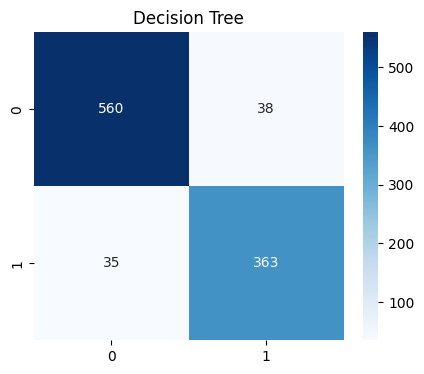

In [12]:
max_depth = grid_search.best_params_["max_depth"]
min_samples_leaf = grid_search.best_params_["min_samples_leaf"]
min_samples_split = grid_search.best_params_["min_samples_split"]

tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
tree.fit(X_train_not_scaled, y_train_not_scaled)

y_pred = tree.predict(X_test_not_scaled)

results.loc[0] = ["Decision Tree", accuracy_score(y_test_not_scaled, y_pred), precision_score(y_test_not_scaled, y_pred, average='macro'),
                  recall_score(y_test_not_scaled, y_pred, average='macro'), f1_score(y_test_not_scaled, y_pred, average='macro')]

print("Accuracy total:", accuracy_score(y_test_not_scaled, y_pred))
print("Recall total:", recall_score(y_test_not_scaled, y_pred, average='macro'))
print("Precision total:", precision_score(y_test_not_scaled, y_pred, average='macro'))
print("F1 total:", f1_score(y_test_not_scaled, y_pred, average='macro'))
print("Reporte de clasificación:\n", classification_report(y_test_not_scaled, y_pred))

cm = confusion_matrix(y_test_not_scaled, y_pred)
plt.figure(figsize=(5, 4))
plt.title("Decision Tree")
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.show()

**3.2 K-Nearest Neighboors**: La técnica de KNN clasifica los datos según la mayoría de los vecinos más cercanos, asignando una etiqueta a un punto de datos basada en las etiquetas de los puntos cercanos. Veamos cómo funciona con nuestros datos.

In [13]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(metric='euclidean')

param_grid = {
    "n_neighbors": range(1, 30),
    "weights": ["uniform", "distance"]
}

grid_search = GridSearchCV(knn, param_grid, cv=10, scoring="accuracy")
grid_search.fit(X_train_scaled, y_train_scaled)

print("Mejores parámetros:", grid_search.best_params_)

Mejores parámetros: {'n_neighbors': 6, 'weights': 'distance'}


Aplicamos KNN con el mejor valor calculado para k.

Accuracy total: 0.9076305220883534
Recall total: 0.8974471017293827
Precision total: 0.9093135558017169
F1 total: 0.9024273891617223
Reporte de clasificación:
                          precision    recall  f1-score   support

neutral or dissatisfied       0.90      0.95      0.92       598
              satisfied       0.92      0.85      0.88       398

               accuracy                           0.91       996
              macro avg       0.91      0.90      0.90       996
           weighted avg       0.91      0.91      0.91       996



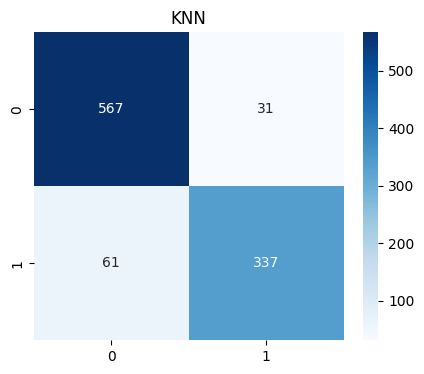

In [14]:
knn = KNeighborsClassifier(n_neighbors=grid_search.best_params_["n_neighbors"], weights=grid_search.best_params_["weights"])
knn.fit(X_train_scaled, y_train_scaled)

y_pred = knn.predict(X_test_scaled)

results.loc[1] = ["KNN", accuracy_score(y_test_scaled, y_pred), precision_score(y_test_scaled, y_pred, average='macro'), 
                  recall_score(y_test_scaled, y_pred, average='macro'), f1_score(y_test_scaled, y_pred, average='macro')]

print("Accuracy total:", accuracy_score(y_test_scaled, y_pred))
print("Recall total:", recall_score(y_test_scaled, y_pred, average='macro'))
print("Precision total:", precision_score(y_test_scaled, y_pred, average='macro'))
print("F1 total:", f1_score(y_test_scaled, y_pred, average='macro'))
print("Reporte de clasificación:\n", classification_report(y_test_scaled, y_pred))

cm = confusion_matrix(y_test_scaled, y_pred)
plt.figure(figsize=(5, 4))
plt.title("KNN")
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.show()

**3.3 Logistic Regression**: Se utiliza para predecir la probabilidad de una variable categórica binaria basada en variables independientes, utilizando una función logística para estimar la relación entre las características y la probabilidad de pertenecer a una clase específica.

In [15]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()

param_grid = {
    "C": np.logspace(-3, 1, 7),
    "penalty": ["l1", "l2"],
    "solver": ["liblinear"]
}

grid_search = GridSearchCV(log_reg, param_grid, cv=10, scoring="accuracy")
grid_search.fit(X_train_scaled, y_train_scaled)

print("Mejores parámetros:", grid_search.best_params_)

Mejores parámetros: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


Accuracy total: 0.8785140562248996
Recall total: 0.8706786440564024
Precision total: 0.8750419792972984
F1 total: 0.8726917214125223
Reporte de clasificación:
                          precision    recall  f1-score   support

neutral or dissatisfied       0.89      0.91      0.90       598
              satisfied       0.86      0.83      0.85       398

               accuracy                           0.88       996
              macro avg       0.88      0.87      0.87       996
           weighted avg       0.88      0.88      0.88       996



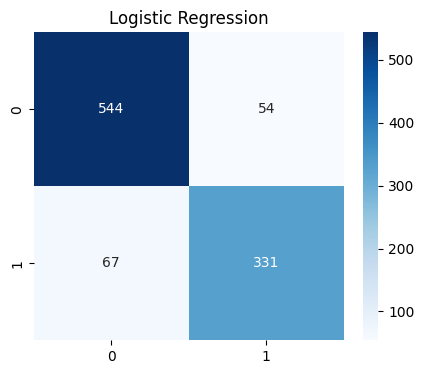

In [16]:
log_reg = LogisticRegression(C=grid_search.best_params_["C"], 
                             penalty=grid_search.best_params_["penalty"], 
                             solver=grid_search.best_params_["solver"])

log_reg.fit(X_train_scaled, y_train_scaled)

y_pred = log_reg.predict(X_test_scaled)

results.loc[2] = ["Logistic Regression", accuracy_score(y_test_scaled, y_pred), precision_score(y_test_scaled, y_pred, average='macro'),
                    recall_score(y_test_scaled, y_pred, average='macro'), f1_score(y_test_scaled, y_pred, average='macro')]

print("Accuracy total:", accuracy_score(y_test_scaled, y_pred))
print("Recall total:", recall_score(y_test_scaled, y_pred, average='macro'))
print("Precision total:", precision_score(y_test_scaled, y_pred, average='macro'))
print("F1 total:", f1_score(y_test_scaled, y_pred, average='macro'))
print("Reporte de clasificación:\n", classification_report(y_test_scaled, y_pred))

cm = confusion_matrix(y_test_scaled, y_pred)
plt.figure(figsize=(5, 4))
plt.title("Logistic Regression")
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.show()

**3.4 SVM**: Son modelos de aprendizaje supervisado que encuentran un límite de decisión óptimo entre clases al encontrar el hiperplano que maximiza el margen entre datos de distintas clases.

In [17]:
from sklearn import svm

svm_model = svm.SVC()

param_grid = {
    "C": np.logspace(-3, 1, 2),
    "kernel": ["linear", "rbf", "sigmoid"],
    "gamma": ["scale", "auto"]
}

grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train_scaled, y_train_scaled)

print("Mejores parámetros:", grid_search.best_params_)

Mejores parámetros: {'C': 10.0, 'gamma': 'auto', 'kernel': 'rbf'}


Accuracy total: 0.9367469879518072
Recall total: 0.9347195845447975
Precision total: 0.9336427837968104
F1 total: 0.9341716961793188
Reporte de clasificación:
                          precision    recall  f1-score   support

neutral or dissatisfied       0.95      0.94      0.95       598
              satisfied       0.92      0.92      0.92       398

               accuracy                           0.94       996
              macro avg       0.93      0.93      0.93       996
           weighted avg       0.94      0.94      0.94       996



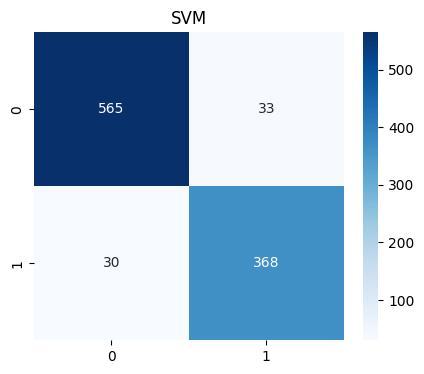

In [18]:
svm = svm.SVC(C=grid_search.best_params_["C"],  
              kernel=grid_search.best_params_["kernel"], 
              gamma=grid_search.best_params_["gamma"])

svm.fit(X_train_scaled, y_train_scaled)

y_pred = svm.predict(X_test_scaled)

results.loc[3] = ["SVM", accuracy_score(y_test_scaled, y_pred), precision_score(y_test_scaled, y_pred, average='macro'),
                    recall_score(y_test_scaled, y_pred, average='macro'), f1_score(y_test_scaled, y_pred, average='macro')]

print("Accuracy total:", accuracy_score(y_test_scaled, y_pred))
print("Recall total:", recall_score(y_test_scaled, y_pred, average='macro'))
print("Precision total:", precision_score(y_test_scaled, y_pred, average='macro'))
print("F1 total:", f1_score(y_test_scaled, y_pred, average='macro'))
print("Reporte de clasificación:\n", classification_report(y_test_scaled, y_pred))

cm = confusion_matrix(y_test_scaled, y_pred)
plt.figure(figsize=(5, 4))
plt.title("SVM")
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.show()

### 4. Resultados

In [19]:
results

,Model,Accuracy,Precision,Recall,F1
0,Decision Tree,0.926707,0.923207,0.924258,0.923723
1,KNN,0.907631,0.909314,0.897447,0.902427
2,Logistic Regression,0.878514,0.875042,0.870679,0.872692
3,SVM,0.936747,0.933643,0.934720,0.934172


### 5. Reglas del árbol de decisión.

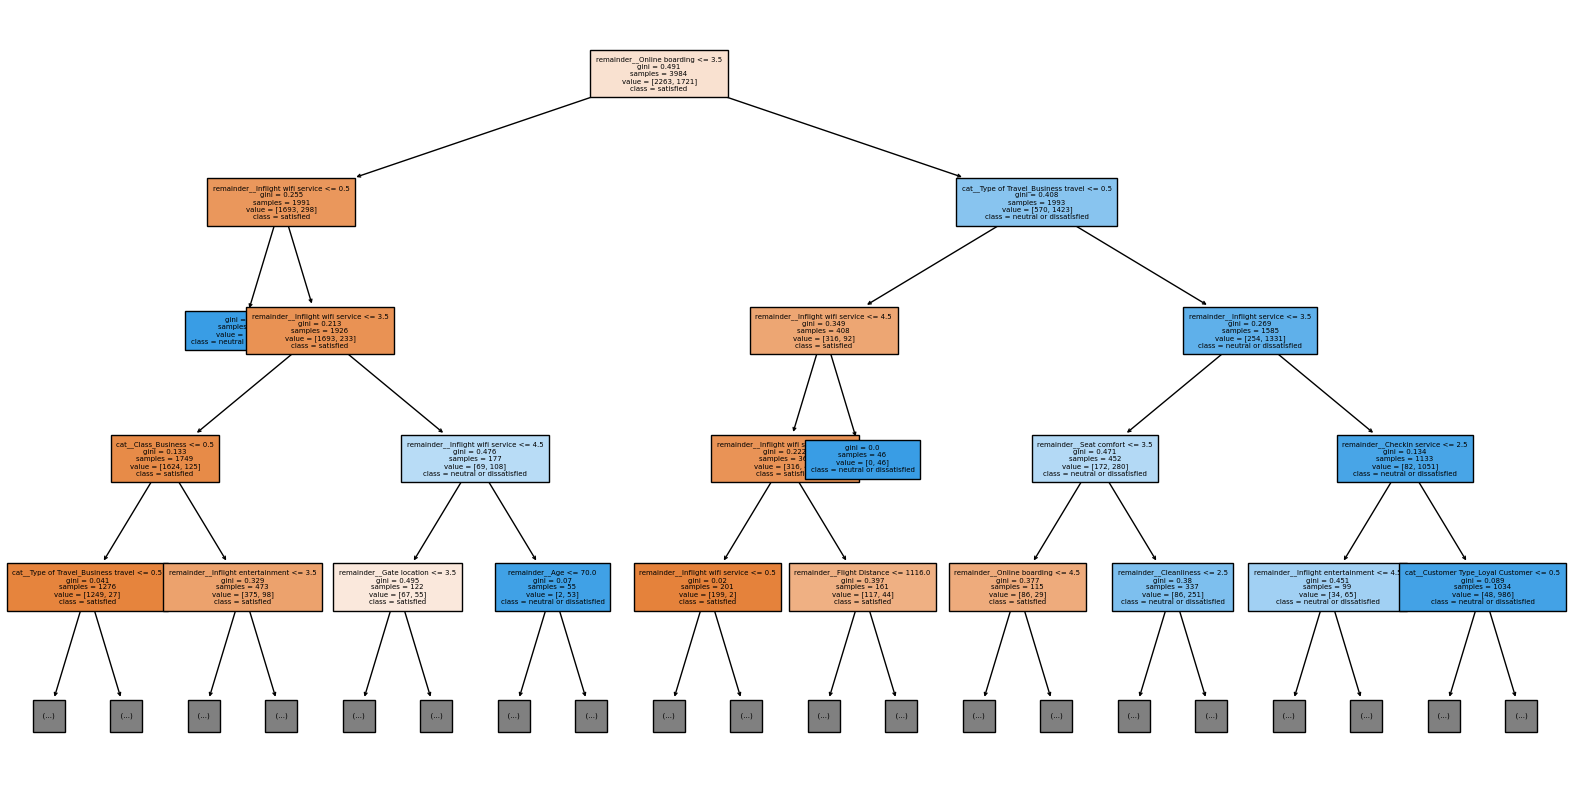

In [20]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True, max_depth=4, fontsize=5, feature_names=X_not_scaled.columns, class_names=["satisfied", "neutral or dissatisfied"])
plt.show()

Identificamos las ramas que nos llevan a nodos con un valor de 'gini' más bajo:

- Online Boarding $\leq 3.5$ **AND** Inflight Wifi Service $\geq 0.5$ **AND** Inflight Wifi Service $\leq 3.5$ **AND** Class Business $\leq 0.5$ **AND** Type of Travel: Personal Travel $\leq 0.5$ ---> **Satisfied**
    
- Online Boarding $\leq 3.5$ **AND** Inflight Wifi Service $\geq 0.5$ **AND** Inflight Wifi Service $\geq 3.5$ **AND** Inflight Wifi Service $\geq 4.5$ **AND** Age $\leq 70$ ---> **Neutral or Dissatisfied**
    
- Online Boarding $\geq 3.5$ **AND** Type of Travel: Personal Travel $\leq 0.5$ **AND** Inflight Service $\geq 3.5$ **AND** Check-in Service $\geq 4.5$ **AND** Type of Customer: Loyal Customer $\leq 70$ ---> **Satisfied**